### Decision Tree

Decision Tree is a flow-chart-like hierarchical tree structure and it is composed of three elements: nodes, edges, and leaves. Nodes represent attributes or variables, edges match the various potential attribute values and lastly, leaves include items that belong to the same class. The main advantages of the decision tree are that it has not assumptions and especially it produces graphical representation, which makes it easier to read and interpret the model. 

#### Import Data and Library 

In this section I create 3 datasets: 
1. Complete Dataset with all data
2. Data of individuals who have a high Climate Change Risk Perception (q2 >= 6) 
2. Data of individuals who have Low Climate Change Risk Perception (q2 <= 5) 

With all datasets I will predict pro-environmental behaviour (qb5). 

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image 
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv('df-climatechange.csv')
df = df.drop([ 'qb1a'], axis = 1)
#df['pro-environmental behaviour'] = df['pro-environmental behaviour'].replace({'No': 0, 'Yes':1})

#two subset
df1 = df[df['risk perception'] >= 6]
df2 = df[df['risk perception'] <= 5]



#### Set parameters for Random Search

In [2]:
param_dict = {
    "criterion": ['gini', 'entropy'], 
    "max_depth": range(1,10), 
    "min_samples_split": range(0 , 10), 
    "min_samples_leaf": range(1,5)
}

param_dict

{'criterion': ['gini', 'entropy'],
 'max_depth': range(1, 10),
 'min_samples_split': range(0, 10),
 'min_samples_leaf': range(1, 5)}

### Complete Dataset

In this part there is the complete dataset. I will predict pro-environmental behaviour (qb5). The predictors are: climate change risk perception, clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 

In [3]:

cc_num = df[['pro-environmental behaviour', 'risk perception' , 'political orientation', 'gender','age', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']]

cat_var =['political orientation','gender', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('pro-environmental behaviour',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'pro-environmental behaviour']


# Create training and validating set
seed = 123  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

In [4]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.43641457, 0.76697577])

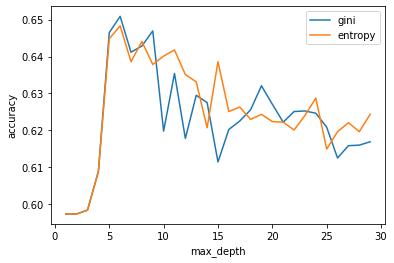

In [25]:
#find  optimal parameters: GINI OR ENTROPY 
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
    dtree = DecisionTreeClassifier(criterion="gini", max_depth=i, class_weight= {0: 1.43631197 , 1:0.76700502})
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
 ####
    dtree = DecisionTreeClassifier(criterion="entropy", max_depth=i, class_weight= {0: 1.43631197 , 1:0.76700502})
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
 ####
    max_depth.append(i)
d = pd.DataFrame({"acc_gini":pd.Series(acc_gini), 
 "acc_entropy":pd.Series(acc_entropy),
 "max_depth":pd.Series(max_depth)})


# visualizing changes in parameters
plt.plot("max_depth","acc_gini", data=d, label="gini")
plt.plot("max_depth","acc_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

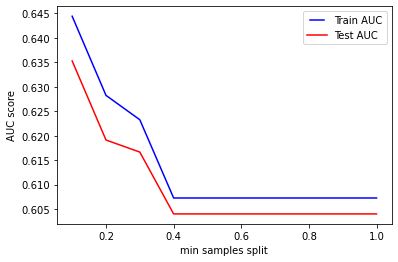

In [6]:
#find min samples split
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split, class_weight= {0: 1.43631197 , 1:0.76700502})
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

#### Grid Search 
Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.

In [8]:
dt = DecisionTreeClassifier(class_weight= {0: 1.43631197 , 1:0.76700502})

dt_classifier = RandomizedSearchCV(dt,param_dict, 
                   cv= 3,
                   n_jobs= -1, random_state = seed)

dt_classifier.fit(X_train, y_train)

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.61667967        nan 0.61810972 0.62272491 0.61375455        nan
        nan 0.62051482 0.62103484        nan]
  category=UserWarning


RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight={0: 1.43631197,
                                                                  1: 0.76700502}),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(0, 10)},
                   random_state=123)

In [9]:
print(dt_classifier.best_params_)
print(dt_classifier.best_estimator_)

{'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 8, 'criterion': 'entropy'}
DecisionTreeClassifier(class_weight={0: 1.43631197, 1: 0.76700502},
                       criterion='entropy', max_depth=8, min_samples_split=4)


In [10]:
print(classification_report(y_test, dt_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.59      0.53      2296
           1       0.75      0.67      0.71      4298

    accuracy                           0.64      6594
   macro avg       0.62      0.63      0.62      6594
weighted avg       0.66      0.64      0.65      6594



#### Pruning decision tree

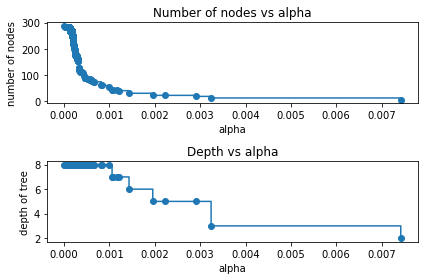

In [12]:

path=DecisionTreeClassifier(random_state=1).\
cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities



clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion = 'entropy' , random_state=seed,ccp_alpha=ccp_alpha, class_weight= {0: 1.43631197 , 1:0.76700502},  max_depth=8, min_samples_split =4, min_samples_leaf = 1)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
    
    

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]


node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

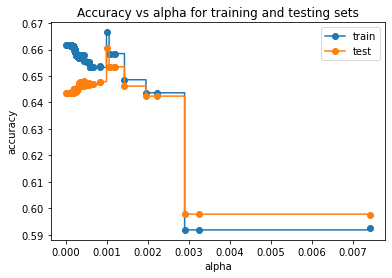

In [13]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()


In [14]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

Training accuracy of best model:  0.6665366614664586
Test accuracy of best model:  0.6607521989687595


In [15]:
best_model

DecisionTreeClassifier(ccp_alpha=0.000993163342228487,
                       class_weight={0: 1.43631197, 1: 0.76700502},
                       criterion='entropy', max_depth=8, min_samples_split=4,
                       random_state=123)

### Best model 

I put the optimal parameters in the best model and I create the graph.

In [5]:
#fit model with best parameters 

clf_pruned = DecisionTreeClassifier(criterion = 'entropy' ,ccp_alpha=0.000993163342228487, random_state=seed, class_weight= {0: 1.43631197 , 1:0.76700502},  max_depth=8, min_samples_split = 4, min_samples_leaf = 1)
clf_pruned.fit(X_train, y_train)
pred = clf_pruned.predict(X_test)
accuracy_score(y_test, pred)
#Accuracy: 0.66


xvar = df_get_dummies.drop('pro-environmental behaviour', axis=1)
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['No Action','Yes Action'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png('dt-prune.png') 



In [6]:
print(classification_report(y_test, clf_pruned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2296
           1       0.74      0.74      0.74      4298

    accuracy                           0.66      6594
   macro avg       0.63      0.63      0.63      6594
weighted avg       0.66      0.66      0.66      6594



#### Confusion Matrix

Text(0.5, 19.5, 'Predicted label')

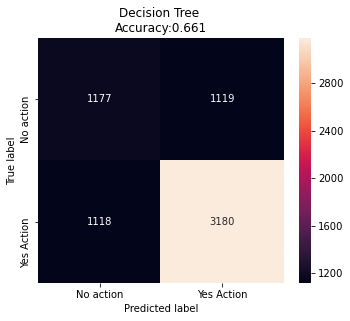

In [7]:
#y_pred = dt.predict(X_test)
ac = accuracy_score(y_test,clf_pruned.predict(X_test))
#print('Accuracy is: ',ac)

cm_df = confusion_matrix(y_test,clf_pruned.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
plt.figure(figsize=(5.5,4.5))
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, clf_pruned.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('dt_confusionmatrix.png')


#### Feature importance


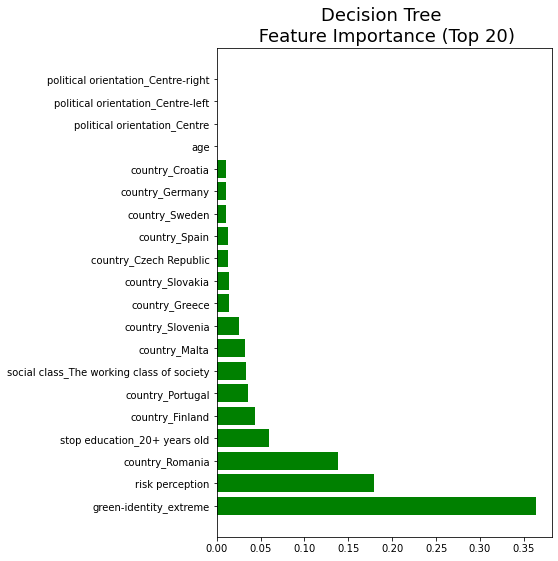

In [8]:
feature_importances = list(zip(X_train, clf_pruned.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 9))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Decision Tree \n Feature Importance (Top 20)',
          fontdict= {'fontsize' : 18})
plt.show()
#plt.savefig('dt_featureimportance.png')


roc_auc_score for Decision Tree:  0.6787569232428016


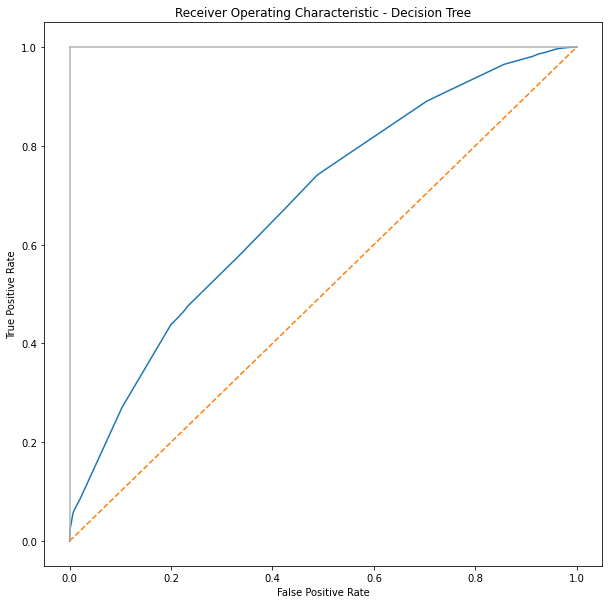

In [9]:
y_score2 = clf_pruned.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Decision Tree: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
imp = pd.read_csv('imp.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)
dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)

dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)

final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[3]: "importance_dt" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)


final.to_csv('imp.csv', index=False, encoding='utf-8')


### High Risk Perception


In this part there is data of individuals who have a high Climate Change Risk Perception (q2 >= 6).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes

In [28]:

cc_num = df1[['pro-environmental behaviour' , 'political orientation', 'gender','age', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']]

cat_var =['political orientation','gender', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('pro-environmental behaviour',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'pro-environmental behaviour']


seed = 101  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights


array([1.56726931, 0.73424266])

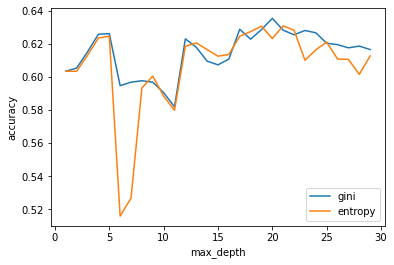

In [18]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
    dtree = DecisionTreeClassifier(criterion="gini", random_state = seed,max_depth=i, class_weight= {0: 1.56739773 , 1:0.73421448} )
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
 ####
    dtree = DecisionTreeClassifier(criterion="entropy",random_state = seed, max_depth=i,  class_weight= {0: 1.56739773 , 1:0.73421448} )
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
 ####
    max_depth.append(i)
d = pd.DataFrame({"acc_gini":pd.Series(acc_gini), 
 "acc_entropy":pd.Series(acc_entropy),
 "max_depth":pd.Series(max_depth)})


# visualizing changes in parameters
plt.plot("max_depth","acc_gini", data=d, label="gini")
plt.plot("max_depth","acc_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

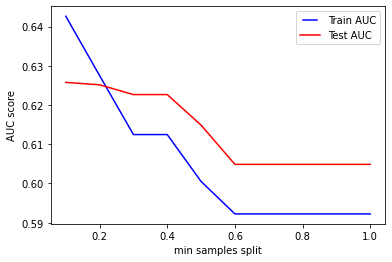

In [5]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split,random_state = seed, class_weight= {0: 1.56739773 , 1:0.73421448} )
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

In [24]:
dt = DecisionTreeClassifier(class_weight= {0: 1.56739773 , 1:0.73421448})
dt_classifier = RandomizedSearchCV(dt,param_dict, 
                   cv= 3,
                   n_jobs= -1,random_state = seed)

dt_classifier.fit(X_train, y_train)

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.59835206 0.58891386 0.62037453 0.62052434 0.59363296        nan
 0.60037453 0.60187266        nan 0.58134831]
  category=UserWarning


RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight={0: 1.56739773,
                                                                  1: 0.73421448}),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(0, 10)},
                   random_state=101)

In [25]:
print(dt_classifier.best_params_)
print(dt_classifier.best_estimator_)

{'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'gini'}
DecisionTreeClassifier(class_weight={0: 1.56739773, 1: 0.73421448}, max_depth=7,
                       min_samples_leaf=3, min_samples_split=6)


#### Pruning Decision Tree

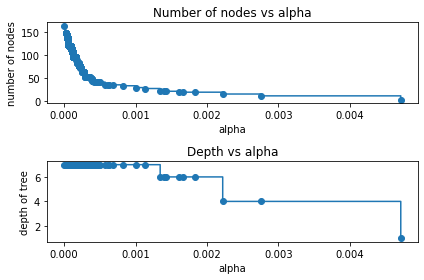

In [26]:
path=DecisionTreeClassifier(random_state=1).\
cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities



clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion = 'gini' , random_state=seed,ccp_alpha=ccp_alpha, class_weight= {0: 1.56739773 , 1:0.73421448},  max_depth=7, min_samples_split = 6, min_samples_leaf = 3)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
    
    

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]


node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

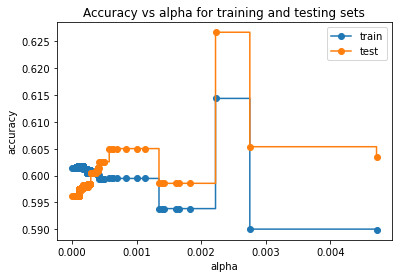

In [27]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [28]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

best_model

Training accuracy of best model:  0.6143820224719101
Test accuracy of best model:  0.6267039496679483


DecisionTreeClassifier(ccp_alpha=0.0022213271836104,
                       class_weight={0: 1.56739773, 1: 0.73421448}, max_depth=7,
                       min_samples_leaf=3, min_samples_split=6,
                       random_state=101)

#### Best Model

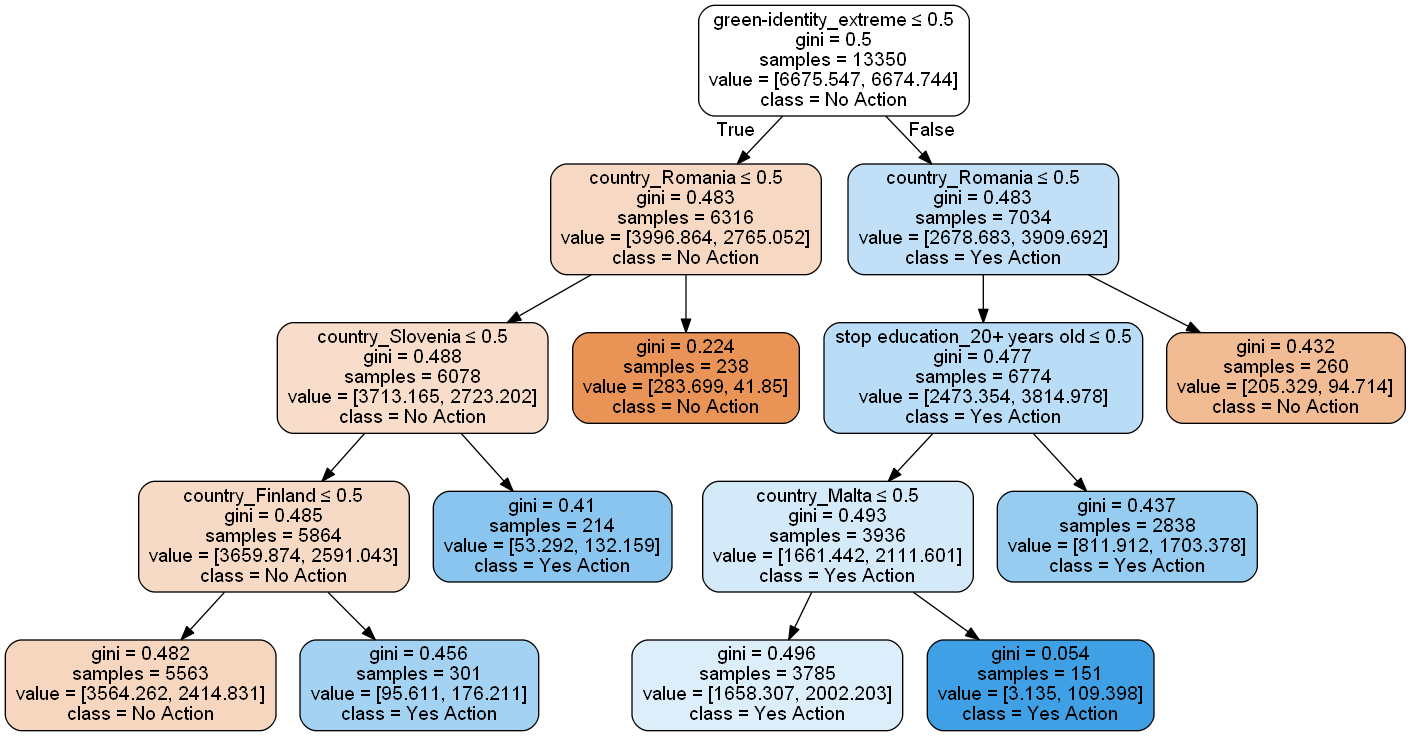

In [29]:
#fit model with best parameters 

clf_pruned = DecisionTreeClassifier(criterion = 'gini' , random_state=seed,ccp_alpha=0.0022213271836104, class_weight= {0: 1.56739773 , 1:0.73421448},  max_depth=7, min_samples_split = 6, min_samples_leaf = 3)
clf_pruned.fit(X_train, y_train)
pred = clf_pruned.predict(X_test)
accuracy_score(y_test, pred)

xvar = df_get_dummies.drop('pro-environmental behaviour', axis=1)
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['No Action','Yes Action'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
#graph.write_png('action-prune2.png') 



In [30]:
print(classification_report(y_test, clf_pruned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.44      0.61      0.51      1825
           1       0.78      0.63      0.70      3897

    accuracy                           0.63      5722
   macro avg       0.61      0.62      0.60      5722
weighted avg       0.67      0.63      0.64      5722



Text(0.5, 19.5, 'Predicted label')

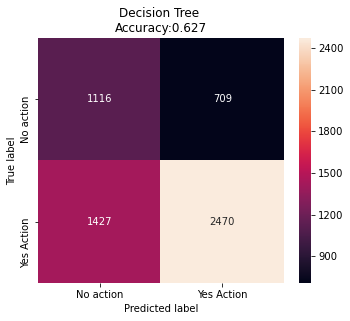

In [31]:
ac = accuracy_score(y_test,clf_pruned.predict(X_test))
plt.figure(figsize=(5.5,4.5))

cm_df = confusion_matrix(y_test,clf_pruned.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, clf_pruned.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


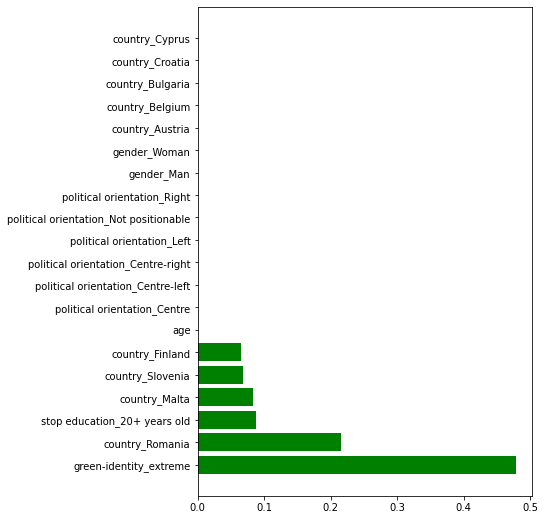

In [32]:
feature_importances = list(zip(X_train, clf_pruned.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 9))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
#plt.title('Decision Tree Feature Importance (Top 20) - High Risk Perception',
#          fontdict= {'fontsize' : 18})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()


roc_auc_score for Random Forest - High Risk Perception:  0.6444104878708946


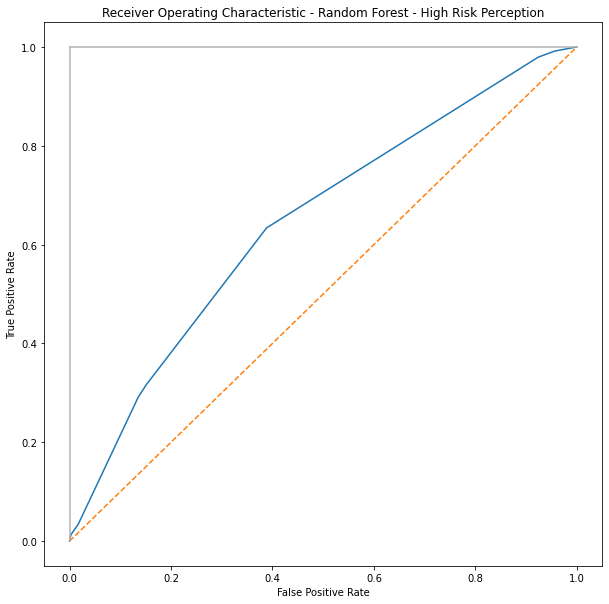

In [18]:
y_score2 =  clf_pruned.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest - High Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Low Risk Perception

In this part there is data of individuals who have a low Climate Change Risk Perception (q2 <= 5).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes


In [19]:
cc_num = df2[['pro-environmental behaviour' , 'political orientation', 'gender','age', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']]

cat_var =['political orientation','gender', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('pro-environmental behaviour',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'pro-environmental behaviour']

seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([0.92707384, 1.08537887])

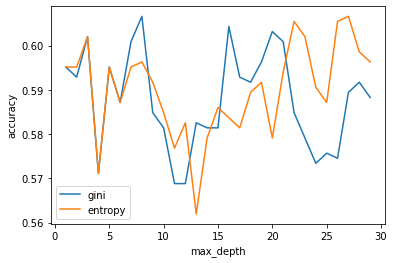

In [36]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
    dtree = DecisionTreeClassifier(criterion="gini", random_state = seed,max_depth=i, class_weight= {0: 0.92727273 , 1:1.08510638} )
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
 ####
    dtree = DecisionTreeClassifier(criterion="entropy",random_state = seed, max_depth=i,  class_weight= {0: 0.92727273 , 1:1.08510638})
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
 ####
    max_depth.append(i)
d = pd.DataFrame({"acc_gini":pd.Series(acc_gini), 
 "acc_entropy":pd.Series(acc_entropy),
 "max_depth":pd.Series(max_depth)})


# visualizing changes in parameters
plt.plot("max_depth","acc_gini", data=d, label="gini")
plt.plot("max_depth","acc_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

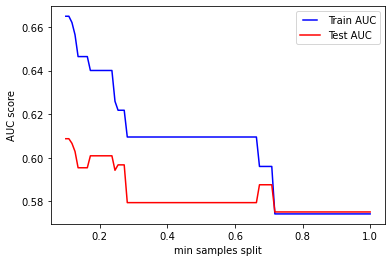

In [37]:

min_samples_splits = np.linspace(0.1, 1.0, 100, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split,random_state = seed, class_weight= {0: 0.92727273 , 1:1.08510638})
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

In [38]:
dt = DecisionTreeClassifier(class_weight={0: 0.92727273 , 1:1.08510638})
dt_classifier = RandomizedSearchCV(dt,param_dict, 
                   cv= 3,
                   n_jobs= -1, random_state = seed)

dt_classifier.fit(X_train, y_train)

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.593412   0.60570305 0.60521141        nan 0.593412   0.5899705
 0.593412   0.61553589 0.58456244        nan]
  category=UserWarning


RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight={0: 0.92727273,
                                                                  1: 1.08510638}),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(0, 10)},
                   random_state=50)

In [39]:
print(dt_classifier.best_params_)
print(dt_classifier.best_estimator_)

{'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
DecisionTreeClassifier(class_weight={0: 0.92727273, 1: 1.08510638},
                       criterion='entropy', max_depth=5, min_samples_leaf=2,
                       min_samples_split=8)


#### Pruning

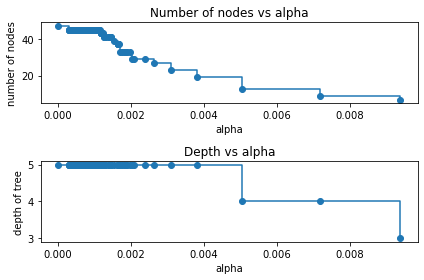

In [40]:
path=DecisionTreeClassifier(random_state=1).\
cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities



clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion = 'entropy' , random_state=seed,ccp_alpha=ccp_alpha, class_weight= {0: 0.92727273, 1: 1.08510638},  max_depth=5, min_samples_split =8, min_samples_leaf = 2)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
    
    

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]


node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

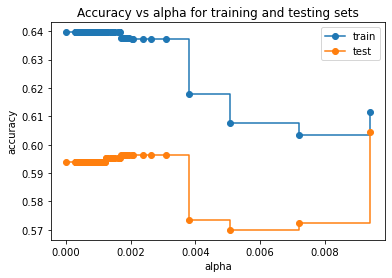

In [41]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [42]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))
best_model

Training accuracy of best model:  0.6116027531956736
Test accuracy of best model:  0.6043577981651376


DecisionTreeClassifier(ccp_alpha=0.009396010830688362,
                       class_weight={0: 0.92727273, 1: 1.08510638},
                       criterion='entropy', max_depth=5, min_samples_leaf=2,
                       min_samples_split=8, random_state=50)

#### Best Model

In [20]:
#fit model with best parameters 

clf_pruned = DecisionTreeClassifier(criterion = 'entropy' , random_state=seed,ccp_alpha=0.009396010830688417, class_weight= {0: 0.92727273, 1: 1.08510638},  max_depth=5, min_samples_split =8, min_samples_leaf = 2)
clf_pruned.fit(X_train, y_train)
pred = clf_pruned.predict(X_test)
accuracy_score(y_test, pred)
#Accuracy: 0.66


xvar = df_get_dummies.drop('pro-environmental behaviour', axis=1)
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['No Action','Yes Action'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png('action-prune3.png') 


In [21]:
print(classification_report(y_test, clf_pruned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.80      0.69       470
           1       0.62      0.37      0.47       402

    accuracy                           0.60       872
   macro avg       0.61      0.59      0.58       872
weighted avg       0.61      0.60      0.58       872



Text(0.5, 19.5, 'Predicted label')

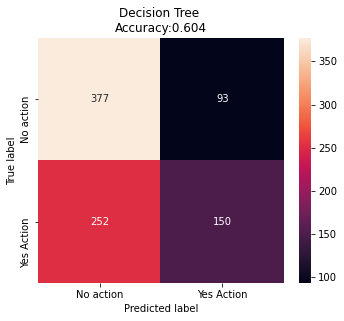

In [22]:
#y_pred = dt.predict(X_test)
ac = accuracy_score(y_test,clf_pruned.predict(X_test))
plt.figure(figsize=(5.5,4.5))

cm_df = confusion_matrix(y_test,clf_pruned.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, clf_pruned.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


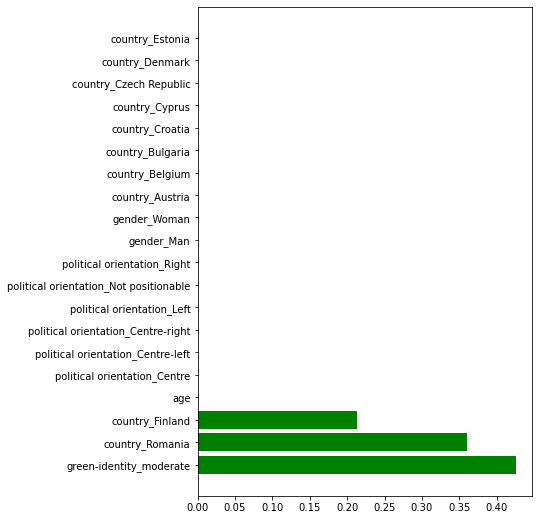

In [23]:
feature_importances = list(zip(X_train, clf_pruned.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
# Plot the top 25 feature importance
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 9))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
#plt.title('Decision Tree - Feature Importance (Top 20) - Low Risk Perception',
#          fontdict= {'fontsize' : 18})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

roc_auc_score for Random Forest - High Risk Perception:  0.6041706361807981


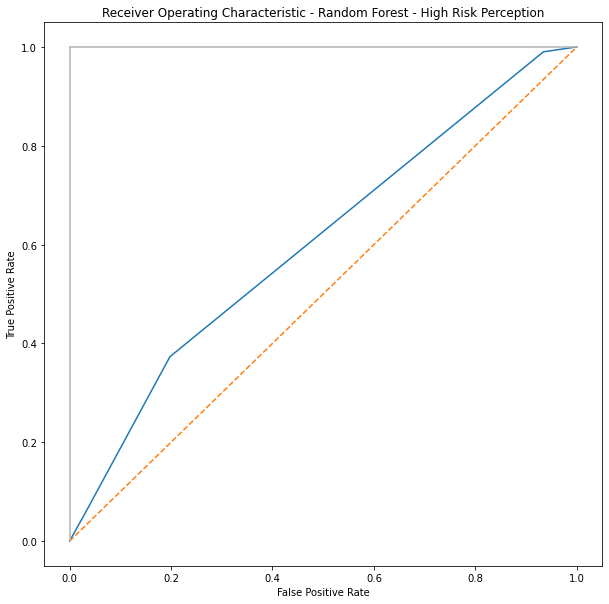

In [27]:
y_score2 = clf_pruned.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest - High Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### REFERENCES

https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93

https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd

https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

https://towardsdatascience.com/decision-tree-classifier-and-cost-computation-pruning-using-python-b93a0985ea77

https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

https://medium.com/ai-in-plain-english/hyperparameter-tuning-of-decision-tree-classifier-using-gridsearchcv-2a6ebcaffeda

https://medium.com/swlh/post-pruning-decision-trees-using-python-b5d4bcda8e23